In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

if torch.cuda.is_available():
    print(f'{torch.cuda.device_count()} GPU is available with CUDA enabled and current device is number {torch.cuda.current_device()} which has a model {torch.cuda.get_device_name()}')
    device = torch.device('cuda:0')
else: device = torch.device('cpu')

# comment this if you have large enough GPU
device = torch.device('cpu')

1 GPU is available with CUDA enabled and current device is number 0 which has a model GeForce GTX 960M


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(torch.nn.Module):
    def __init__(self, num_classes): 
        super(AlexNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4), # (96, 1, 55, 55)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # (96, 1, 27, 27)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2), # (256, 1, 27, 27)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # (256, 13, 13)
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1), # (384, 1, 13, 13)
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1), # (384, 1, 13, 13)
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1), # (256, 1, 13, 13)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # (256, 1, 6, 6)
            nn.AvgPool2d((6, 6)) # (256, 1, 6, 6)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5), # (256 * 1 * 6 * 6 = 9216)
            nn.Linear(256 * 1 * 6 * 6, 4096), # (1, 4096)
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096), # (1, 4096)
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes) # (1, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x)
        x = self.classifier(x)
        return x

class DenseNet(torch.nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()

        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        self.conv_layers = self.densenet121.features
        # self.conv_layers = self.densenet121.features[:-1]
        # self.batchpool2d = self.densenet121.features[-1]
        self.classifier_layers = self.densenet121.classifier
        self.gradients = None
    
    def forward(self, x):
        features = self.conv_layers(x)
        h = features.register_hook(self.activations_hook)
        # out = self.batchpool2d(features)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier_layers(out)
        return out
    
    def activations_hook(self, grad):
        self.gradients = grad
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.conv_layers(x)

class InceptionV3(torch.nn.Module):
    def __init__(self):
        super(InceptionV3, self).__init__()

        self.inception_v3 = torchvision.models.inception_v3(pretrained=True)

        self.classifier = nn.Sequential(
            self.inception_v3.Conv2d_1a_3x3,
            self.inception_v3.Conv2d_2a_3x3,
            self.inception_v3.Conv2d_2b_3x3,
            self.inception_v3.maxpool1,
            self.inception_v3.Conv2d_3b_1x1,
            self.inception_v3.Conv2d_4a_3x3,
            self.inception_v3.maxpool2,
            self.inception_v3.Mixed_5b,
            self.inception_v3.Mixed_5c,
            self.inception_v3.Mixed_5d,
            self.inception_v3.Mixed_6a,
            self.inception_v3.Mixed_6b,
            self.inception_v3.Mixed_6c,
            self.inception_v3.Mixed_6d,
            self.inception_v3.Mixed_6e,
            self.inception_v3.Mixed_7a,
            self.inception_v3.Mixed_7b,
            self.inception_v3.Mixed_7c
        )
        self.avg_adaptive_pool = self.inception_v3.avgpool
        self.dropout_inc = self.inception_v3.dropout
        self.fully_connected = self.inception_v3.fc

        self.gradients = None
    
    def forward(self, x):
        x = self.classifier(x)

        h = x.register_hook(self.activations_hook)

        # Adaptive average pooling
        x = self.avg_adaptive_pool(x)
        # N x 2048 x 1 x 1
        x = self.dropout_inc(x)
        # N x 2048 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 2048
        x = self.fully_connected(x)
        # N x 1000 (num_classes)
        return x
    
    def activations_hook(self, grad):
        self.gradients = grad
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.classifier(x)


In [3]:
IMG_HEIGHT = 300
IMG_WIDTH = 300

In [4]:
import torchvision.transforms as transforms

def load_data(data_folder, batch_size):
    _mean = [0.485, 0.456, 0.406]
    _std = [0.229, 0.224, 0.225]
    _mean = [0.4, 0.4, 0.4]
    _std = [0.4, 0.4, 0.4]

    transform = transforms.Compose(
        [
            transforms.Resize([IMG_HEIGHT, IMG_WIDTH]),
            # transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4, 0.4, 0.4], std=[0.4, 0.4, 0.4])
        ]
    )
    data = torchvision.datasets.ImageFolder(root = data_folder, transform=transform)

    # uncomment to individually find out the meand and standard deviation
    # blue_means = []
    # green_means = []
    # red_means = []
    # blue_stds = []
    # green_stds = []
    # red_stds = []
    # for img, _class in data:
    #     blue, green, red    = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    #     blue_means.append(blue.mean())
    #     green_means.append(green.mean())
    #     red_means.append(red.mean())

    #     blue_stds.append(blue.mean())
    #     green_stds.append(green.mean())
    #     red_stds.append(red.mean())
    # means = [np.array(red_means).mean(), np.array(green_means).mean(), np.array(blue_means).mean()]
    # stds = [np.array(red_stds).mean(), np.array(green_stds).mean(), np.array(blue_stds).mean()]
    # print(means, stds)
    
    print(f'Total mean to normalize for three channels: {_mean}', f'Total std to normalize for three channels: {_std}')
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=0)
    return data_loader 
train_data = load_data('datasets/wave/training', 72)
test_data = load_data('datasets/wave/testing', 30)

Total mean to normalize for three channels: [0.4, 0.4, 0.4] Total std to normalize for three channels: [0.4, 0.4, 0.4]
Total mean to normalize for three channels: [0.4, 0.4, 0.4] Total std to normalize for three channels: [0.4, 0.4, 0.4]


Train datasets shape
Feature batch shape: torch.Size([72, 3, 300, 300])
Labels batch shape: torch.Size([72])

Test datasets shape
Feature batch shape: torch.Size([30, 3, 300, 300])
Labels batch shape: torch.Size([30])

Random 4 images from train-test dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


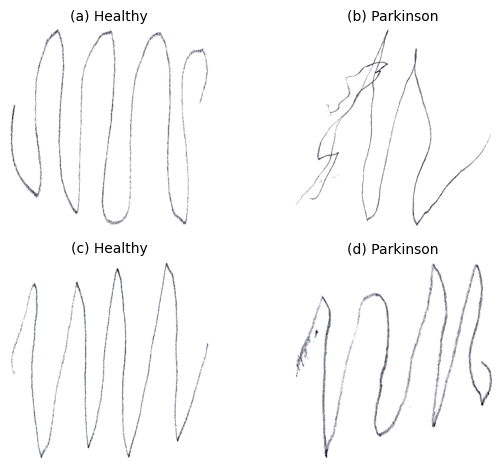

In [5]:
# Display image and label.
def show_images(imgs, imgs_title, cmap=None):
    if len(imgs) > 8: raise ValueError('Length of the parameter exceeded the limit!')
    class_names = {0: 'Healthy', 1: 'Parkinson'}
    for i, val in enumerate(imgs):
        plt.subplot(2, 4, i + 1)
        plt.imshow(imgs[i].numpy().transpose((1, 2, 0)), cmap=cmap)
        plt.title(class_names[int(imgs_title[i])], fontdict = {'fontsize' : 10})
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def get_sample_img(_data, _s):
    for val in _data:
        for idx, lab in enumerate(val[1]):
            if lab == 0 and len(h_train_test_sam)==_s: h_train_test_sam.append((val[0][idx], 'Healthy'))
            if lab == 1 and len(p_train_test_sam)==_s: p_train_test_sam.append((val[0][idx], 'Parkinson')) 

# train datasets shapes
print('Train datasets shape')
train_features, train_labels = next(iter(train_data))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

print('\nTest datasets shape')
test_features, test_labels = next(iter(test_data))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")

print('\nRandom 4 images from train-test dataset')
h_train_test_sam = []
p_train_test_sam = []
get_sample_img(train_data, 0)
get_sample_img(test_data, 1)
plt.subplot(2, 2, 1)
plt.imshow(h_train_test_sam[0][0].numpy().transpose((1, 2, 0)), cmap=None)
plt.title('(a) ' + h_train_test_sam[0][1], fontdict = {'fontsize' : 10})
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(p_train_test_sam[0][0].numpy().transpose((1, 2, 0)), cmap=None)
plt.title('(b) ' + p_train_test_sam[0][1], fontdict = {'fontsize' : 10})
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(h_train_test_sam[1][0].numpy().transpose((1, 2, 0)), cmap=None)
plt.title('(c) ' + h_train_test_sam[1][1], fontdict = {'fontsize' : 10})
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(p_train_test_sam[1][0].numpy().transpose((1, 2, 0)), cmap=None)
plt.title('(d) ' + p_train_test_sam[1][1], fontdict = {'fontsize' : 10})
plt.axis('off')
plt.tight_layout()
plt.savefig('images/sample_train_test_wave.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# this descriptor is for none transfer learning approach
def feature_descriptor(data_loader, net):
    features, features_labels = [], []
    for i, data in enumerate(data_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        for img in inputs:
            # for i in range(100):
            with torch.no_grad():
                _feat = net(img.view(1, 1, IMG_HEIGHT, IMG_WIDTH))
            features.append(_feat.cpu().detach().numpy())
    features_labels.append(labels.cpu().detach().numpy())
    return (np.array(features), np.array(features_labels))

In [8]:
# this descriptor is for none Cam-Grad
def feature_descriptor_transfer(data_loader):
    densenet121 = torchvision.models.densenet121(pretrained=True)
    densenet121 = densenet121.to(device)
    densenet121.eval()

    # to get features from forward pass register a pytorch hook
    features = []
    fc_weights = []
    def feature_hook(module, input, output):
        number_of_image, number_of_channel, height, width = output.shape
        output = output.reshape(number_of_image, number_of_channel, -1)
        features.append(output.mean(dim=2).cpu().detach().numpy())
        fc_weights.append(densenet121.classifier.weight.data.cpu().data.numpy())

    _ = densenet121._modules.get('features').register_forward_hook(feature_hook)

    for index, data in enumerate(data_loader, 0):
        input_images, labels = data
        input_images, labels = input_images.to(device), labels.to(device)
        densenet121(input_images)

    features = np.concatenate(features)
    
    _.remove()
    del densenet121

    return (features, labels.cpu().detach().numpy(), fc_weights[0])

In [9]:
# this descriptor is for getting Cam-Grad
densenet121 = DenseNet()
densenet121 = densenet121.to(device)
densenet121.eval()

def feature_descriptor_gradcam(data_loader):
    print('Getting Features...')
    for index, data in enumerate(data_loader, 0):
        input_images, labels = data
        input_images, labels = input_images.to(device), labels.to(device)
        features = densenet121(input_images)
    print(f'Features shape: {features.shape}\n')

    print('Computing gradients...')
    features.backward(torch.ones_like(features))
    print('\n\n')

    # computing gradients
    gradients = densenet121.get_activations_gradient()
    print(f'Gradients shape: {gradients.shape}\n\n')


    print('Computing activations...')
    # get the activations of the last convolutional layer
    activations = densenet121.get_activations(input_images).detach()
    print(f'Activations shape: {activations.shape}\n\n')
    
    return (gradients, activations, features, labels)

In [23]:
# Grad-Cam section
import cv2

def gen_heat_map(gradients, activations):
    means_of_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # weight the channels by corresponding gradients
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= means_of_gradients[i]
        
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    return heatmap

def combine_heat_org_img(heatmap, orginal_img):
    heatmap = heatmap.permute(1, 0)[:, :]
    heatmap = heatmap.numpy()
    
    heatmap = cv2.resize(heatmap, (orginal_img.shape[1], orginal_img.shape[2]))

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    orginal_img = orginal_img.permute(2, 1, 0)[:, :, :].numpy()
    orginal_img = np.uint8(255 * orginal_img)

    combined_img = heatmap * 0.5 + orginal_img 
    return combined_img

def show_grad_cam_grid(original_img, heatmap_img, gradcam_img, imgs_title, sample_title):
    def _get_sample_img():
        for idx, lab in enumerate(imgs_title):
            if lab == 0 and len(grad_h)==0: grad_h.append((original_img[idx], gradcam_img[idx], 'Healthy'))
            if lab == 1 and len(grad_p)==0: grad_p.append((original_img[idx], gradcam_img[idx], 'Parkinson')) 
    # class_names = {0: 'Healthy', 1: 'Parkinson'}
    # for i in range(4):
    #     plt.subplot(1, 4, i + 1)
    #     plt.imshow(original_img[i].numpy().transpose((1, 2, 0)))
    #     plt.title(class_names[int(imgs_title[i])], fontdict = {'fontsize' : 10})
    #     plt.axis('off')
    # plt.tight_layout() 
    # plt.savefig('images/densenet121_wave/sample_of_original_img(' + sample_title + ').png',bbox_inches='tight')
    # plt.show()
    grad_h = []
    grad_p = []
    _get_sample_img()
    plt.subplot(2, 2, 1)
    plt.imshow(grad_h[0][0].numpy().transpose((1, 2, 0)))
    plt.title('(a) ' + grad_h[0][-1], fontdict = {'fontsize' : 10})
    plt.axis('off')
    plt.subplot(2, 2, 2)
    plt.imshow(cv2.rotate(cv2.flip(np.uint8(grad_h[0][1]), 1), cv2.ROTATE_90_COUNTERCLOCKWISE))
    plt.colorbar()
    plt.title('(b) ' + grad_h[0][-1], fontdict = {'fontsize' : 10})
    plt.axis('off')
    plt.subplot(2, 2, 3)
    plt.imshow(grad_p[0][0].numpy().transpose((1, 2, 0)))
    plt.title('(c) ' + grad_p[0][-1], fontdict = {'fontsize' : 10})
    plt.axis('off')
    plt.subplot(2, 2, 4)
    plt.imshow(cv2.rotate(cv2.flip(np.uint8(grad_p[0][1]), 1), cv2.ROTATE_90_COUNTERCLOCKWISE))
    plt.colorbar()
    plt.title('(d) ' + grad_p[0][-1], fontdict = {'fontsize' : 10})
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/densenet121_wave/evaluation/grad_cam.png', dpi=300, bbox_inches='tight')
    plt.show()
    # for i in range(4):
    #     plt.subplot(1, 4, i + 1)
    #     plt.matshow(heatmap_img[i].permute(1, 0)[:, :].numpy(), fignum=0)
    #     plt.title(class_names[int(imgs_title[i])], fontdict = {'fontsize' : 10})
    #     plt.axis('off')
    # plt.tight_layout() 
    # plt.savefig('images/densenet121_wave/sample_of_heatmap_img(' + sample_title + ').png',bbox_inches='tight')
    # plt.show()

    # for i in range(4):
    #     plt.subplot(1, 4, i + 1)
    #     plt.imshow(np.uint8(gradcam_img[i]))
    #     plt.title(class_names[int(imgs_title[i])], fontdict = {'fontsize' : 10})
    #     plt.axis('off')
    # plt.tight_layout() 
    # plt.savefig('images/densenet121_wave/sample_of_gradcam_img(' + sample_title + ').png',bbox_inches='tight')
    # plt.show()

In [11]:
train_gradients, train_activations, train_features, train_labels = feature_descriptor_gradcam(train_data)
print(f'\n\nTrain features shape: {train_features.shape}', f'Train labels shape: {train_labels.shape}')

test_gradients, test_activations, test_features, test_labels = feature_descriptor_gradcam(test_data)
print(f'Test features shape: {test_features.shape}', f'Test labels shape: {test_labels.shape}')

train_labels = train_labels.reshape(-1).numpy()
test_labels = test_labels.reshape(-1).numpy()

print('Pickling the data...')
train_tuple = [(train_features[i].detach().numpy(), train_labels[i]) for i in range(len(train_labels))]
train_df = pd.DataFrame(data = train_tuple, columns=('train_features', 'train_labels'))

test_tuple = [(test_features[i].detach().numpy(), test_labels[i]) for i in range(len(test_labels))]
test_df = pd.DataFrame(data = test_tuple, columns=('test_features', 'test_labels'))

train_df.to_pickle('pickles/densenet121_wave(train).pkl')
test_df.to_pickle('pickles/densenet121_wave(test).pkl')
print('pickling completed...')

Getting Features...
Features shape: torch.Size([72, 1000])

Computing gradients...



Gradients shape: torch.Size([72, 1024, 9, 9])


Computing activations...
Activations shape: torch.Size([72, 1024, 9, 9])




Train features shape: torch.Size([72, 1000]) Train labels shape: torch.Size([72])
Getting Features...
Features shape: torch.Size([30, 1000])

Computing gradients...



Gradients shape: torch.Size([30, 1024, 9, 9])


Computing activations...
Activations shape: torch.Size([30, 1024, 9, 9])


Test features shape: torch.Size([30, 1000]) Test labels shape: torch.Size([30])
Pickling the data...
pickling completed...


Grad-Cam on train data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


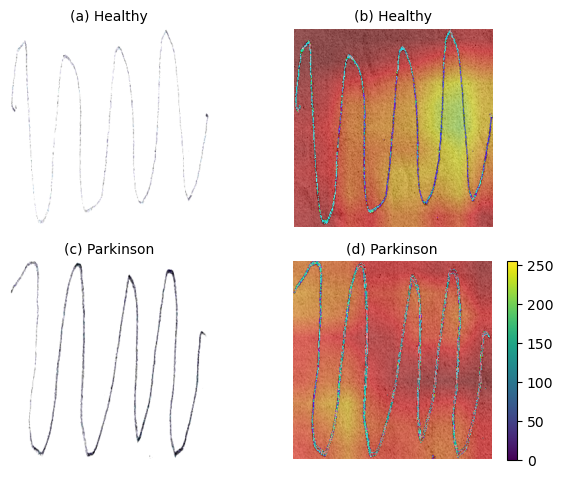

In [24]:
def gen_heatmap_gridcam(gradients, activations, orginal_img):
    gridcam_org_combine = []
    heatmap = gen_heat_map(gradients, activations)
    for i in range(4):
        _gridcam_org_combine = combine_heat_org_img(heatmap[i], orginal_img[i])
        gridcam_org_combine.append(_gridcam_org_combine)
    return (heatmap, gridcam_org_combine)

print('Grad-Cam on train data')
for val in train_data:
    heatmap, gridcam_org_combine = gen_heatmap_gridcam(train_gradients, train_activations, val[0][:4])
    show_grad_cam_grid(val[0][:4], heatmap, gridcam_org_combine, val[1][:4], 'train')
# print('\n\nGrad-Cam on test data')
# for val in test_data:
#     heatmap, gridcam_org_combine = gen_heatmap_gridcam(test_gradients, test_activations, val[0][:4])
#     show_grad_cam_grid(val[0][:4], heatmap, gridcam_org_combine, val[1][:4], 'test')

In [11]:
# if have the pickled file start from here after excuting the first code palette 
try:
    train_df = train_df 
    test_df = test_df 
except: 
    train_df = pd.read_pickle('pickles/densenet121_wave(train).pkl')
    test_df = pd.read_pickle('pickles/densenet121_wave(test).pkl')

print(train_df.head())
print(test_df.head())

                                      train_features  train_labels
0  [-2.3693197, -2.319559, -1.1626883, -0.8814398...             0
1  [-2.6478815, -2.2415223, 0.33295217, -0.388594...             1
2  [-3.4531586, -2.3935847, -1.3567231, -1.730556...             0
3  [-3.152251, -2.6842399, -0.21514732, -0.211788...             0
4  [-3.1731668, -2.5178103, -0.93625176, -0.95587...             0
                                       test_features  test_labels
0  [-2.5097456, -2.2640762, 0.28509712, -0.005190...            1
1  [-2.3890374, -0.8627939, -1.7279408, -2.515861...            0
2  [-2.9998941, -2.7804375, -0.6289813, -0.904408...            0
3  [-3.6763506, -2.4098969, 0.11517656, -0.231838...            0
4  [-2.8196049, -3.162887, -0.37431753, 0.2422759...            0


In [12]:
x_train, y_train = train_df.train_features.tolist(), train_df.train_labels
x_test, y_test = test_df.test_features.tolist(), test_df.test_labels

In [13]:
# model training tasks
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def train_model(classifier, params):
  _ = GridSearchCV(classifier(), params, n_jobs=-1)
  _.fit(x_train, y_train) 
  predict_test = _.predict(x_test)
  print(f'Result for {classifier.__name__}')
  print ("Accuracy: ", accuracy_score(y_test, predict_test)*100, "%")
  print("Best Params: ", _.best_params_, '\n')
  return (classifier.__name__, _.best_estimator_)

models = [
    train_model(
        SVC, 
        {
            "C": [1, 1.01, 2, 3, 0.1],
            "kernel": ["rbf", "poly", "linear"],
            "degree": [1, 2, 3],
            "gamma": ["scale", "auto"]
            }
    ), 
    train_model(
        KNeighborsClassifier, 
        {
            "n_neighbors": [10, 11, 12],
            "weights": ["uniform", "distance"],
            "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
            "leaf_size": [10, 11, 12],
            "p": [1, 2, 3]
        }
    ), 
    train_model(
        LogisticRegression, 
        {
            "penalty": ['l1', 'l2', 'elasticnet', 'none'],
            "C": [1, 1.01, 2, 3, 0.1],
            "fit_intercept": [True, False],
            "random_state": [None, 46],
            "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
        }
    ), 
    train_model(
        DecisionTreeClassifier, 
        {
            "criterion": ['gini', 'entropy'],
            "splitter": ['best', 'random'],
            "max_depth": [None, 10, 50, 100],
            "min_samples_split": [2, 10, 18, 30],
            "min_samples_leaf": [1, 2, 3, 10],
            "random_state": [None, 46]
        }
    )
]

Result for SVC
Accuracy:  96.66666666666667 %
Best Params:  {'C': 3, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'} 

Result for KNeighborsClassifier
Accuracy:  90.0 %
Best Params:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 

Result for LogisticRegression
Accuracy:  90.0 %
Best Params:  {'C': 1, 'fit_intercept': True, 'penalty': 'l2', 'random_state': None, 'solver': 'newton-cg'} 

Result for DecisionTreeClassifier
Accuracy:  83.33333333333334 %
Best Params:  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': None, 'splitter': 'random'} 



In [19]:
# Ensemble section
from sklearn.ensemble import BaggingClassifier

print('BaggingClassifier:\n\n')
bagging_models = []
for name, model in models:
    bc = BaggingClassifier(base_estimator=model, n_estimators=200, n_jobs=-1)
    bc.fit(x_train, y_train)
    y_pred = bc.predict(x_test)
    bagging_models.append((name, bc))
    print(f'{name}: {accuracy_score(y_test, y_pred) * 100}%')

BaggingClassifier:


SVC: 96.66666666666667%
KNeighborsClassifier: 93.33333333333333%
LogisticRegression: 93.33333333333333%
DecisionTreeClassifier: 90.0%


In [16]:
# visualization tasks
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier.rocauc import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve

def show_images(imgs, index, imgs_title, cmap=None):
    if len(index) > 8: raise ValueError('Length of the parameter exceeded the limit!')
    for i, val in enumerate(index):
        plt.subplot(2, 4, i + 1)
        plt.imshow(imgs[val], cmap=cmap)
        plt.title(class_names[imgs_title[val]], fontdict = {'fontsize' : 10})
        plt.axis('off')
    plt.tight_layout()
    plt.show()

#obtain class labels for future use 
class_names = {0: 'Healthy', 1: 'Parkinson'}
list_of_classes = list(class_names.keys())

def classification_report(models, name=None):
    def _(model):
        visualizer = ClassificationReport(model, classes=list_of_classes, support=True, encoder=class_names)
        visualizer.fit(x_train, y_train)
        visualizer.score(x_test, y_test)
        visualizer.save('images/densenet121_wave/evaluation/classification_report.png', dpi=300, bbox_inches='tight')
        return visualizer.poof()
    for idx, model in enumerate(models):
        if np.array(name).any(): print(name[idx])
        ax = plt.subplot(1,1,1)
        _(model)

def class_prediction_error(models, name=None):
    def _(model):
        visualizer = ClassPredictionError(model, classes=list_of_classes, encoder=class_names)
        visualizer.fit(x_train, y_train)
        visualizer.score(x_test, y_test)
        visualizer.save('images/densenet121_wave/evaluation/class_prediction_error.png', dpi=300, bbox_inches='tight')
        return visualizer.poof()  
    for idx, model in enumerate(models):
        if np.array(name).any(): print(name[idx])
        ax = plt.subplot(1,1,1)
        _(model)

def confusion_matrix(models, name=None):
    def _(model):
        visualizer = ConfusionMatrix(model, classes=list_of_classes, percent=True, encoder=class_names)
        visualizer.fit(x_train, y_train)
        visualizer.score(x_test, y_test)
        visualizer.save('images/densenet121_wave/evaluation/confusion_matrix.png', dpi=300, bbox_inches='tight')
        return visualizer.poof()  
    for idx, model in enumerate(models):
        if np.array(name).any(): print(name[idx])
        ax = plt.subplot(1,1,1)
        _(model)
        
def roc_auc(models, name=None):  
    def _(model):
        visualizer = ROCAUC(model, classes=list_of_classes, encoder=class_names)
        visualizer.fit(x_train, y_train)
        visualizer.score(x_test, y_test)
        visualizer.save('images/densenet121_wave/evaluation/roc_auc.png', dpi=300, bbox_inches='tight')
        return visualizer.poof()  
    for idx, model in enumerate(models):
        if np.array(name).any(): print(name[idx])
        ax = plt.subplot(1,1,1)
        _(model)

def precision_recall_curve(models, name=None):
    def _(model):
        visualizer = PrecisionRecallCurve(model, classes=list_of_classes, per_class=True, iso_f1_curves=False, fill_area=False, micro=False, encoder=class_names)
        visualizer.fit(x_train, y_train)
        visualizer.score(x_test, y_test)
        visualizer.save('images/densenet121_wave/evaluation/precision_recall_curve.png', dpi=300, bbox_inches='tight')
        return visualizer.poof()  
    for idx, model in enumerate(models):
        if np.array(name).any(): print(name[idx])
        ax = plt.subplot(1,1,1)
        _(model)

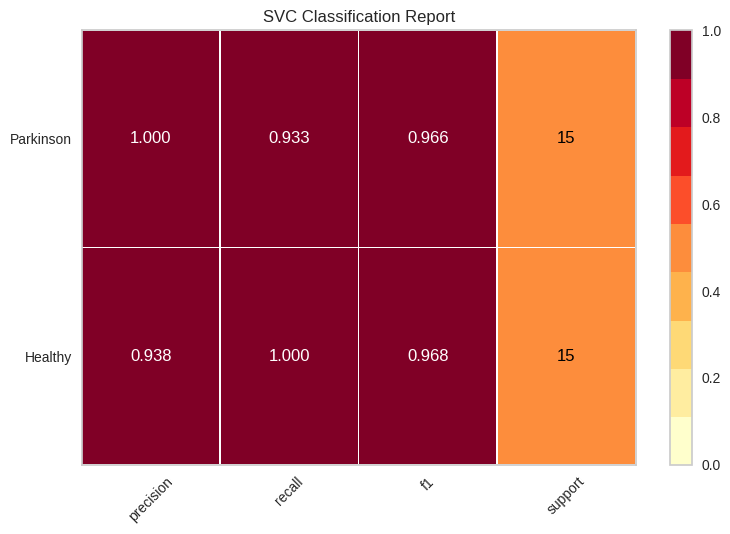

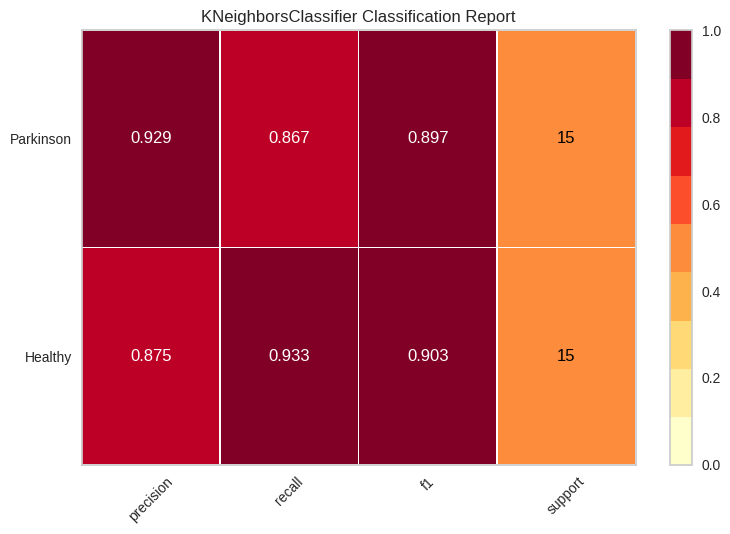

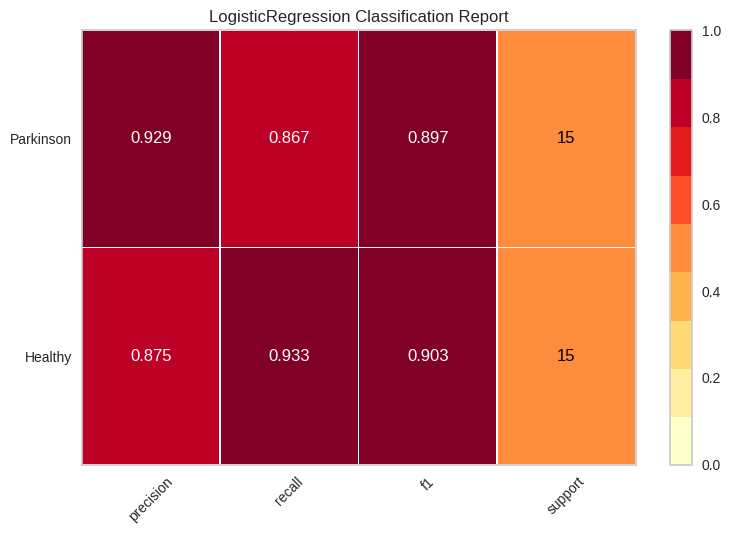

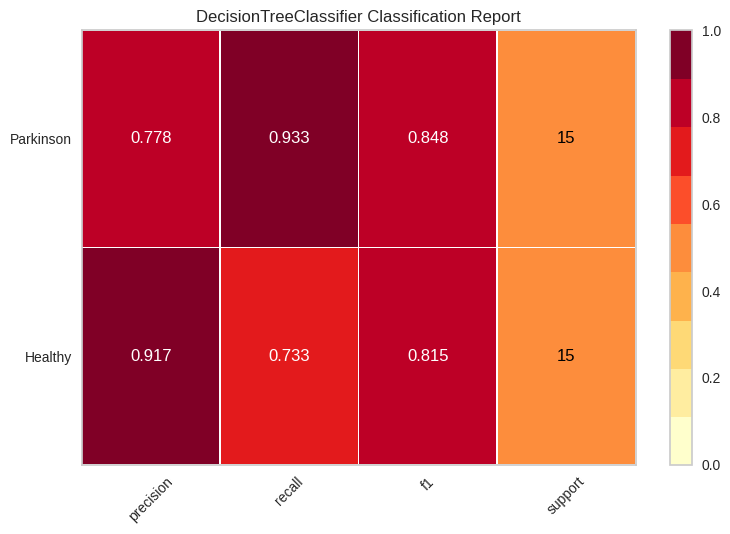

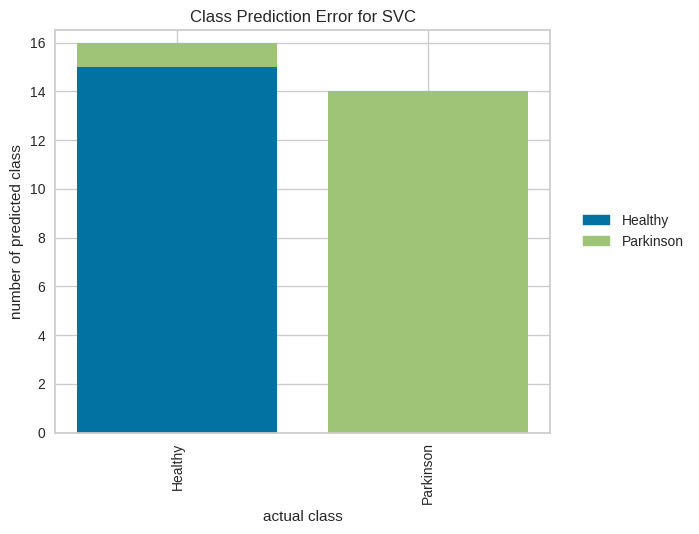

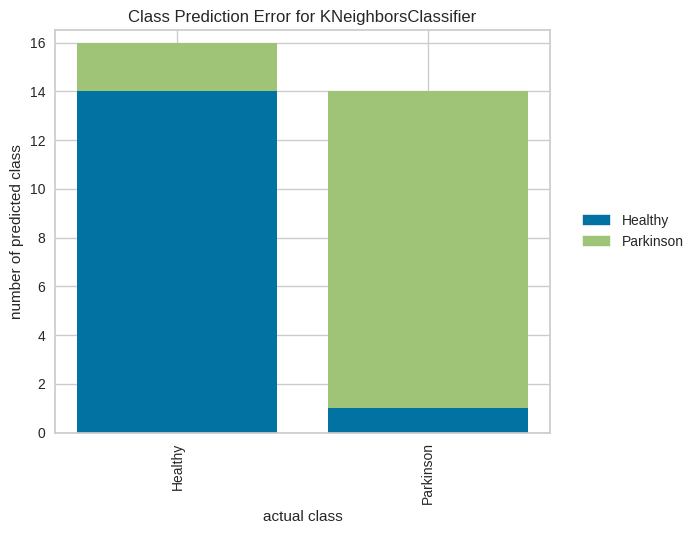

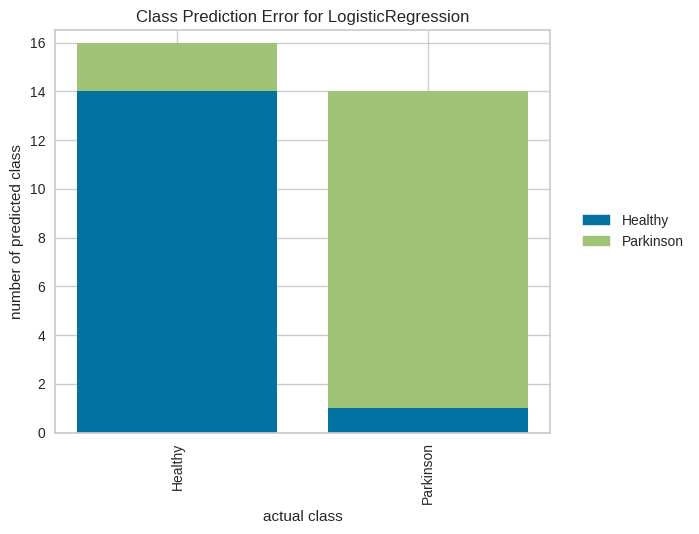

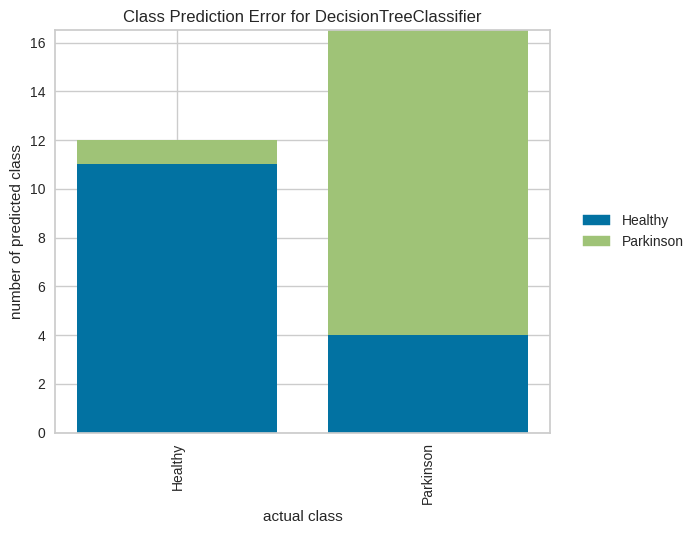

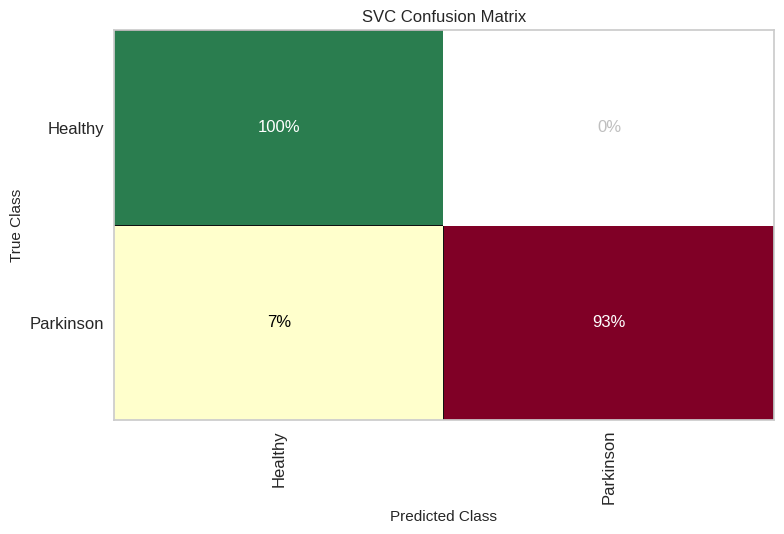

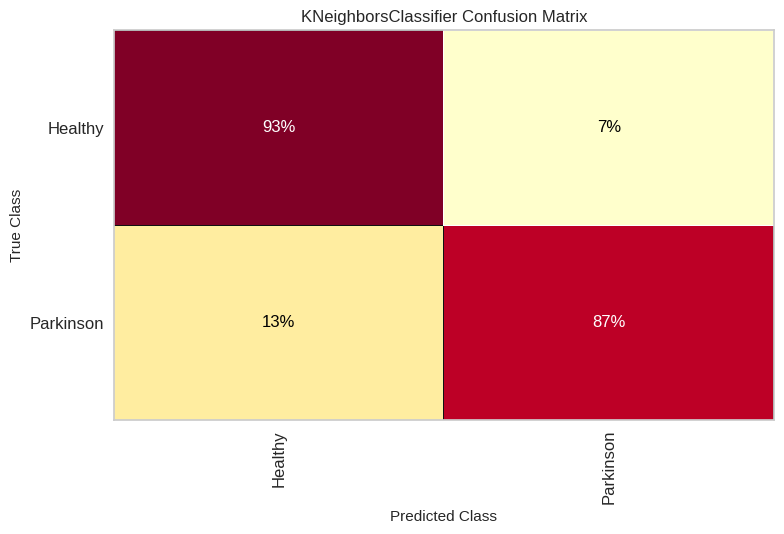

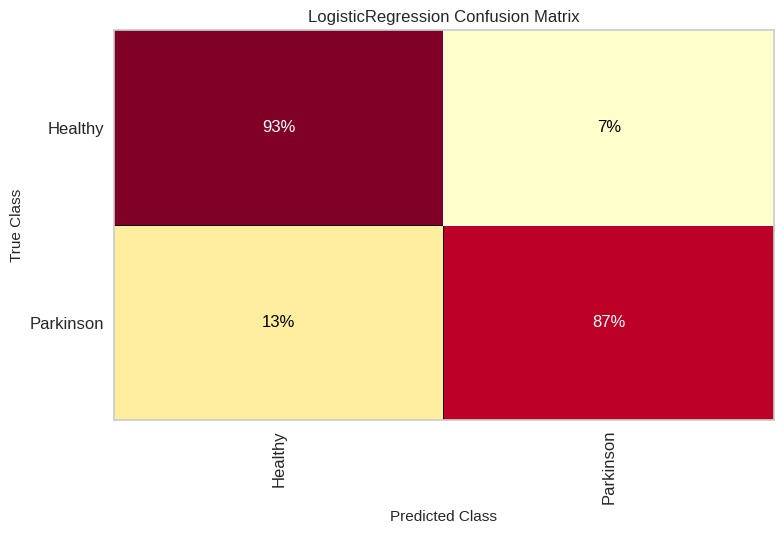

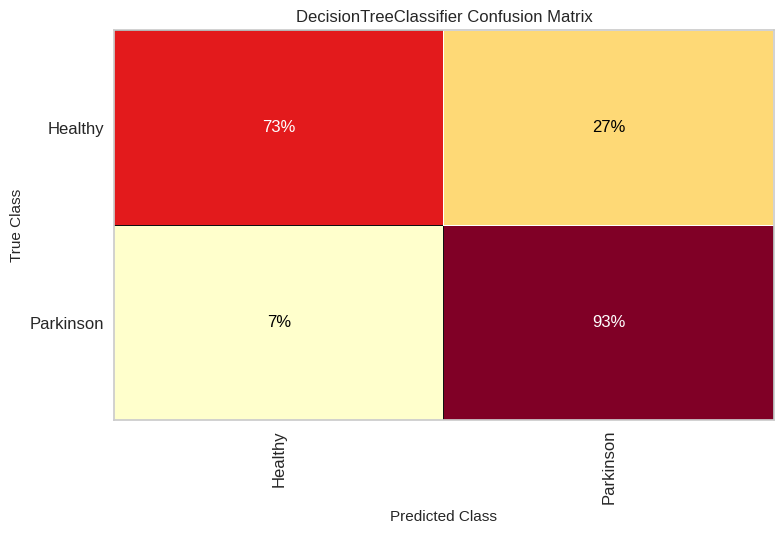

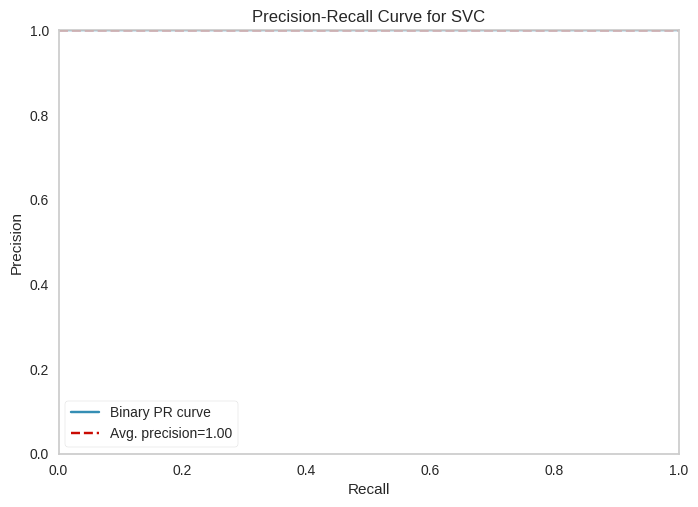

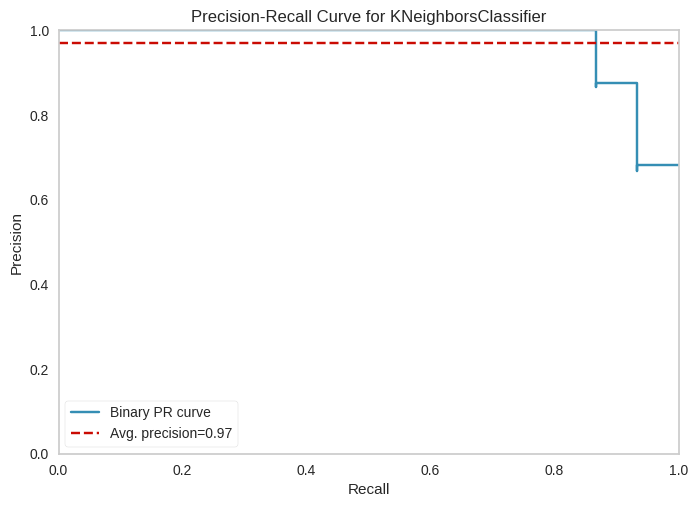

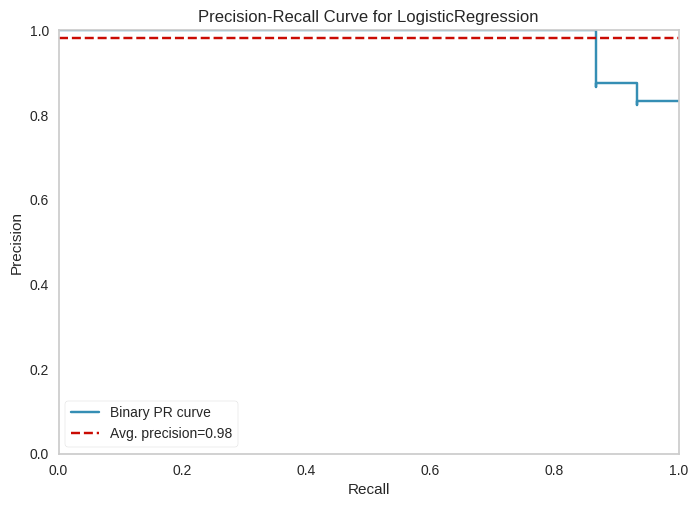

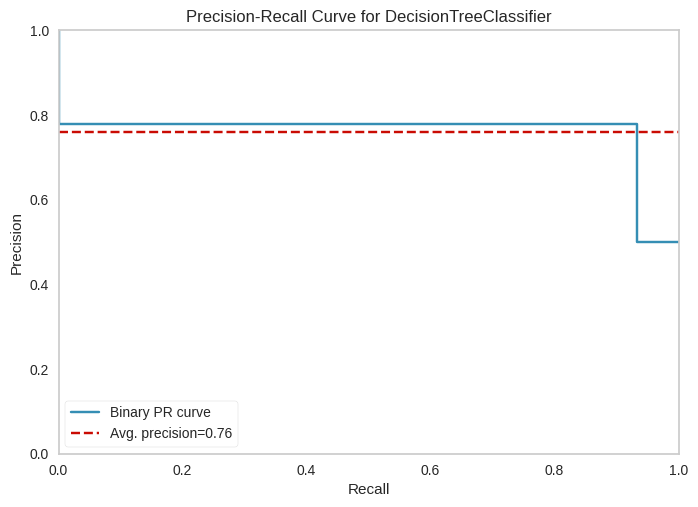

In [17]:
classification_report(np.array(models)[:, 1])
class_prediction_error(np.array(models)[:, 1])
confusion_matrix(np.array(models)[:, 1])
precision_recall_curve(np.array(models)[:, 1])

SVC


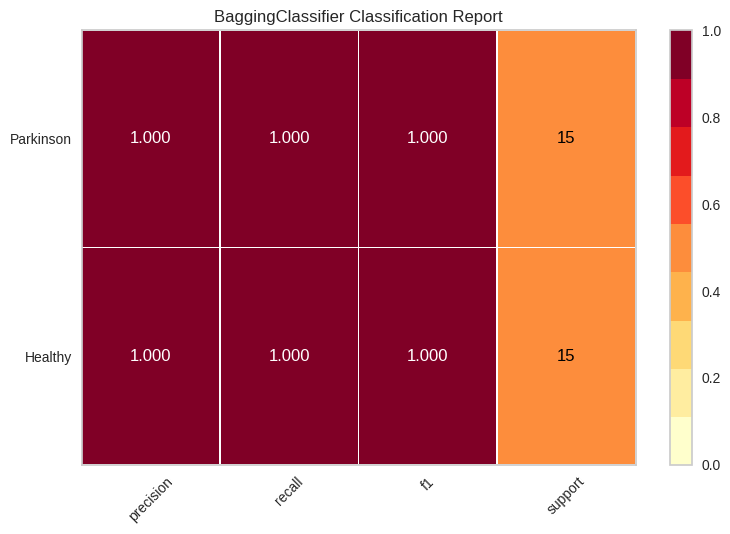

KNeighborsClassifier


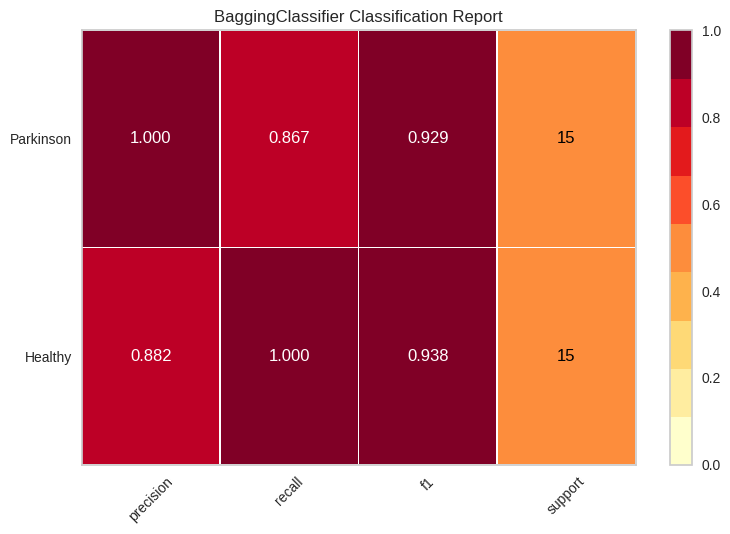

LogisticRegression


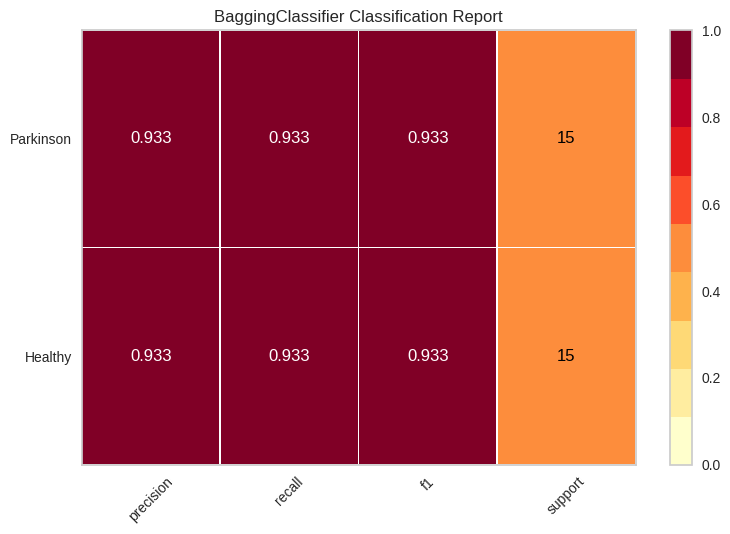

DecisionTreeClassifier


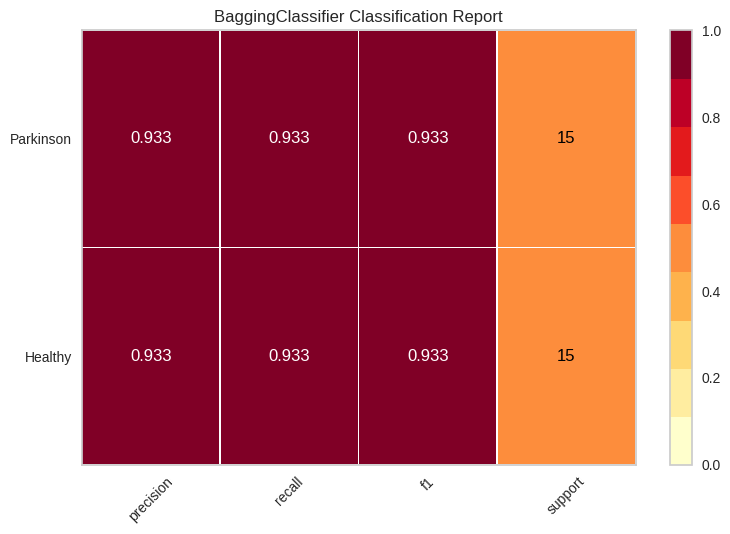

SVC


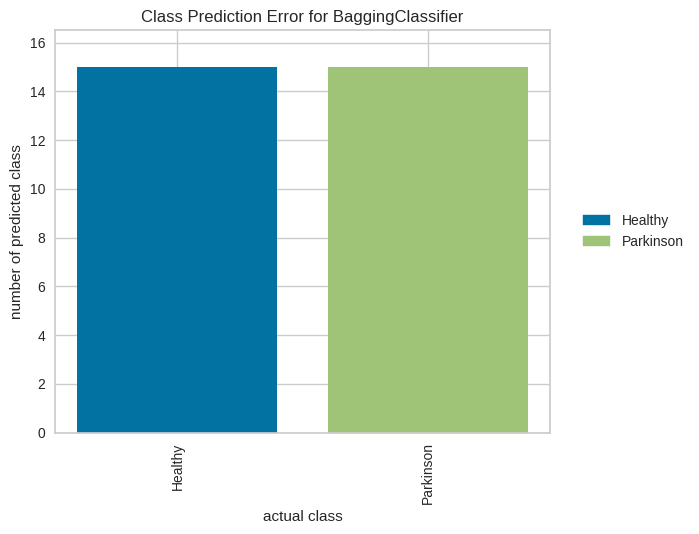

KNeighborsClassifier


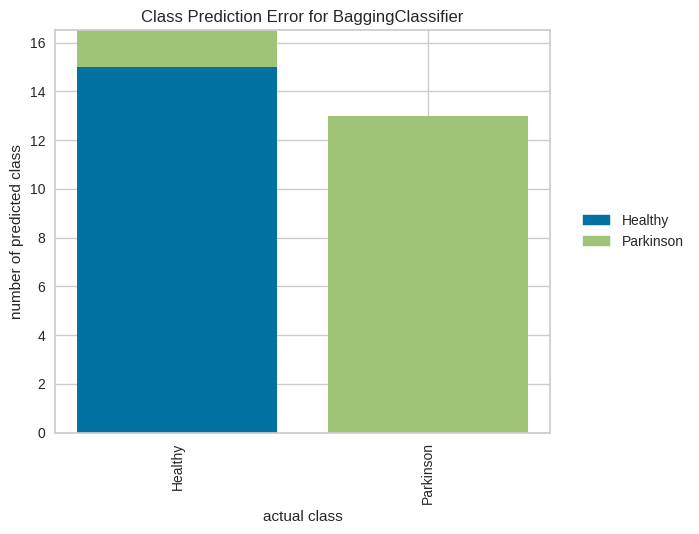

LogisticRegression


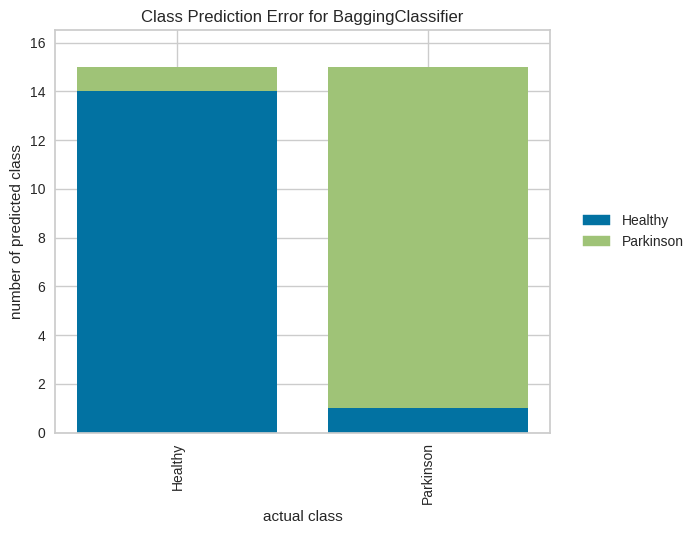

DecisionTreeClassifier


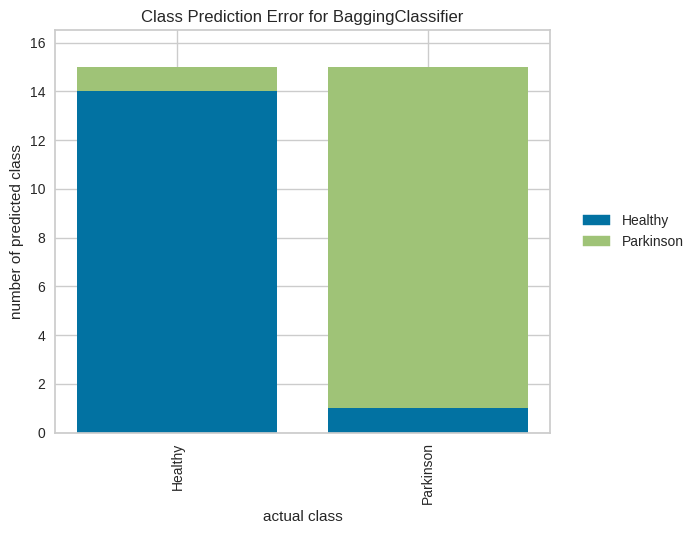

SVC


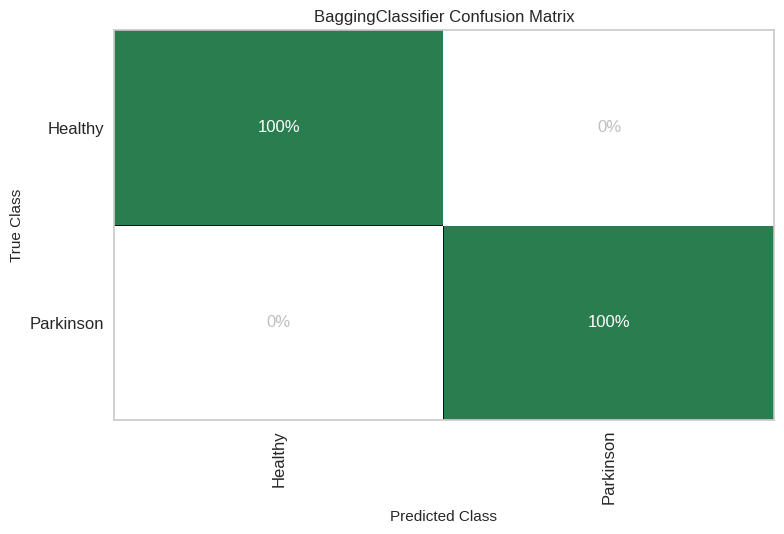

KNeighborsClassifier


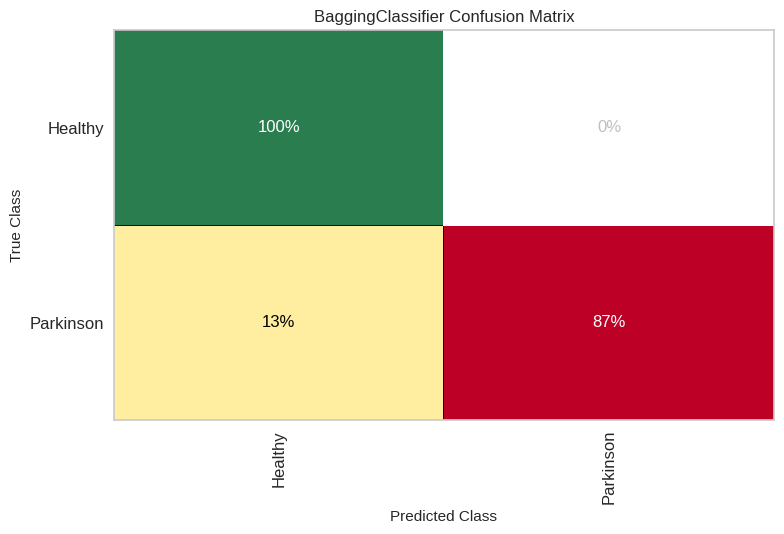

LogisticRegression


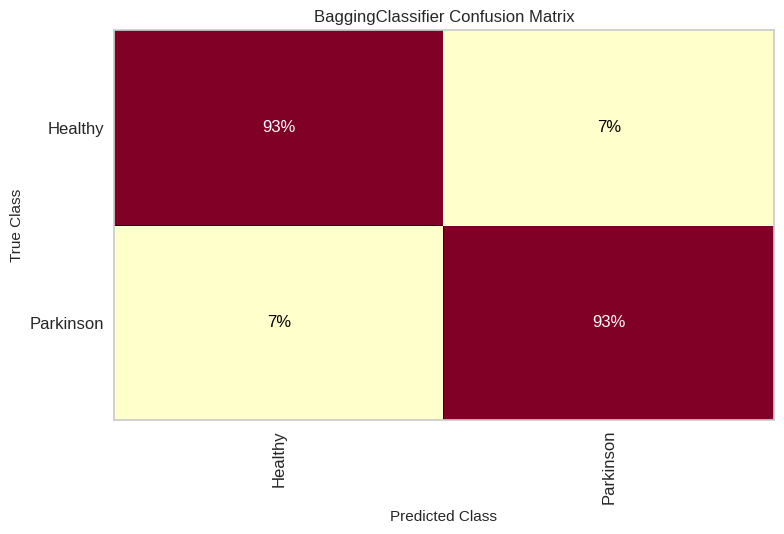

DecisionTreeClassifier


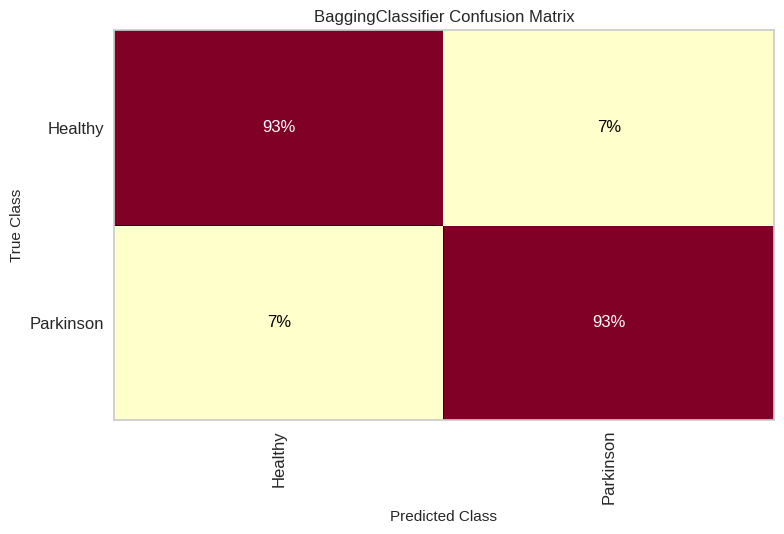

SVC


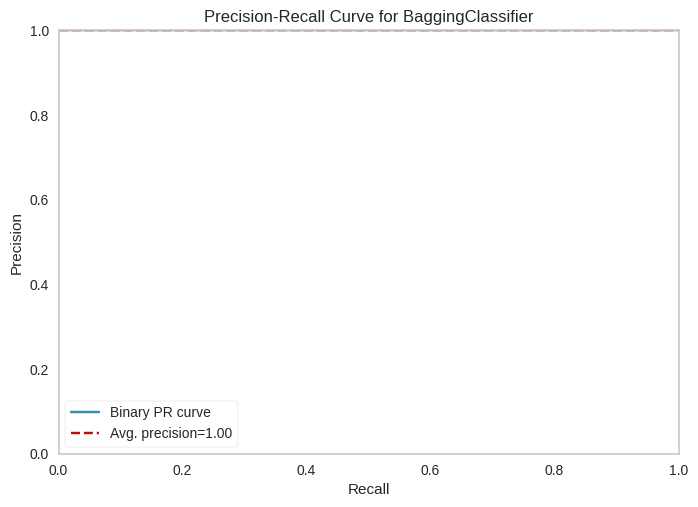

KNeighborsClassifier


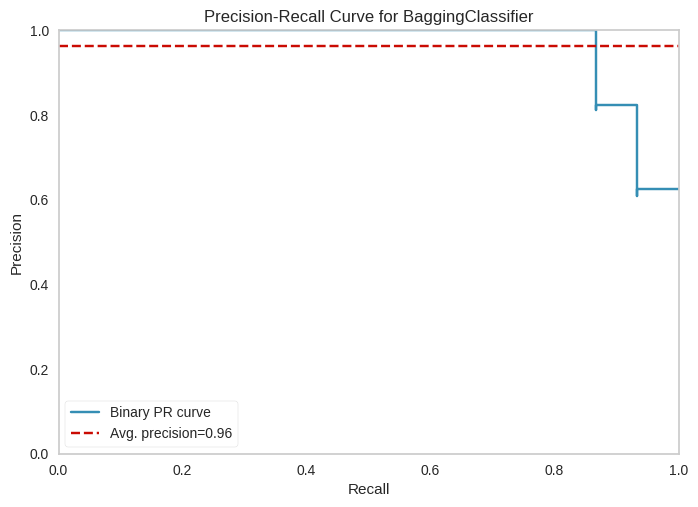

LogisticRegression


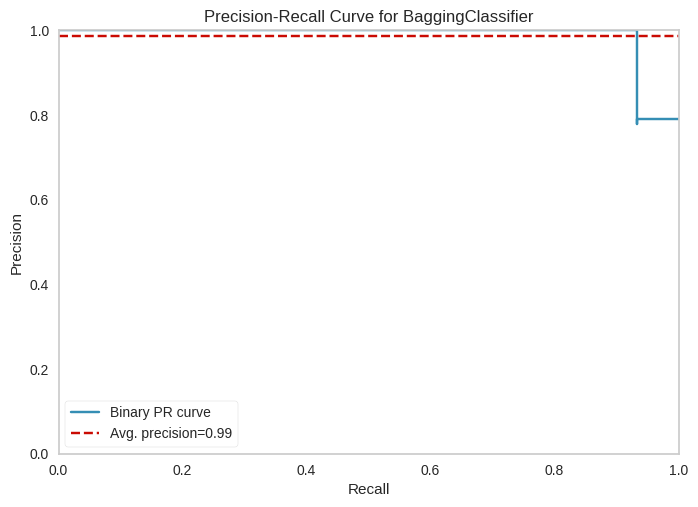

DecisionTreeClassifier


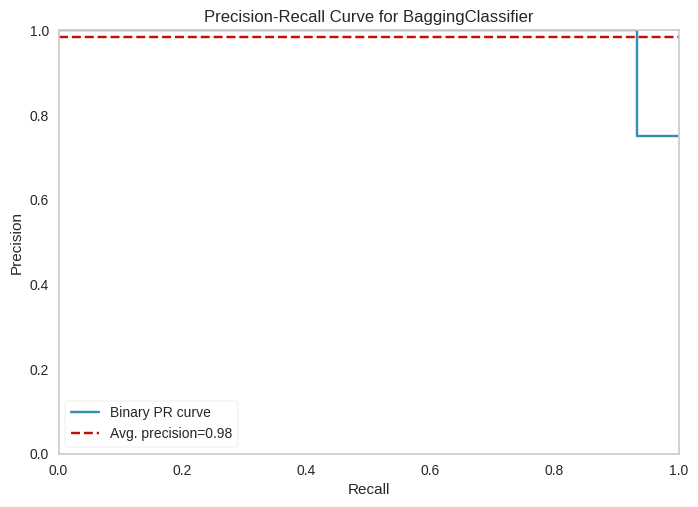

In [18]:
# ensemple results
classification_report(np.array(bagging_models)[:, 1], np.array(bagging_models)[:, 0])
class_prediction_error(np.array(bagging_models)[:, 1], np.array(bagging_models)[:, 0])
confusion_matrix(np.array(bagging_models)[:, 1], np.array(bagging_models)[:, 0])
precision_recall_curve(np.array(bagging_models)[:, 1], np.array(bagging_models)[:, 0])